In [1]:

import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from scipy import sparse
import pyLDAvis.gensim
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.linear_model import Ridge
import seaborn as sns

/home/misha/environments/my_env/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
 # –¶–µ–ª–µ–≤–æ–π –ø—Ä–∏–∑–Ω–∞–∫ - —á–∏—Å–ª–æ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π (–ª–∞–π–∫–æ–≤) —Å—Ç–∞—Ç—å–∏, 
    # –ø—Ä–∏–≤–µ–¥–µ–Ω–Ω—ã–µ –≤ —Å—Ç–∞—Ç—å–µ –∑–Ω–∞—á–µ–Ω–∏—è - –ª–æ–≥–∞—Ä–∏—Ñ–º —Å –µ–¥–∏–Ω–∏—Ü–µ–π
    # –æ—Ç —á–∏—Å–ª–∞ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π
path_to_train = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/train.json'
path_to_data = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/'


In [4]:
!ls -l $path_to_data

–∏—Ç–æ–≥–æ 3806312
-rw-rw-r-- 1 misha misha     874228 –¥–µ–∫ 11 21:52 first_ridge3.csv
-rw-rw-r-- 1 misha misha     870760 –¥–µ–∫ 11 22:03 first_ridge4.csv
-rw-rw-r-- 1 misha misha     870760 –¥–µ–∫ 11 18:07 first_ridge.csv
-rw-rw-r-- 1 misha misha     528309 –¥–µ–∫ 14 13:18 MediumArticle_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     848271 –¥–µ–∫ 25 17:55 MediumArticle_Ridge_baseline_tf-idf_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     735235 –¥–µ–∫ 22 13:14 MediumArticle_Ridge_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha      76041 –¥–µ–∫ 25 18:17 MediumArticle_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     884217 –Ω–æ—è 29  2019 sample_submission.csv
-rw-rw-r-- 1 misha misha 1156020029 –Ω–æ—è 29  2019 test.json
-rw-rw-r-- 1 misha misha     555138 –Ω–æ—è 29  2019 test_log1p_recommends.csv
-rw-rw-r-- 1 misha misha 2086185062 –Ω–æ—è 29  2019 train.json
-rw-rw-r-- 1 misha misha     912544 –Ω–æ—è 29  2019 train_log1p_recommends.csv
-rw-rw-r-- 1 misha misha  648268208 –¥–µ–∫ 11 15:37 train

#### –§—É–Ω–∫—Ü–∏—è –¥–ª—è —á—Ç–µ–Ω–∏—è JSON —Ñ–∞–π–ª–∞ (–±–µ–∑ —Å–±–æ–µ–≤ –ø—Ä–∏ –∏—Å–ø. escape-—Å–∏–º–≤–æ–ª–æ–≤)

In [5]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result



#### –§—É–Ω–∫—Ü–∏—è, –±–µ—Ä—É—â–∞—è json —Ñ–∞–π–ª, —É–±–∏—Ä–∞—é—â–∞—è html-—Ç–µ–≥–∏, –∏ –æ—Å—Ç–∞–≤–ª—è—é—â–∞—è —Ç–æ–ª—å–∫–æ —Ç–µ–∫—Å—Ç —Å—Ç–∞—Ç—å–∏

In [6]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list



In [7]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=\
                               os.path.join(path_to_data, 
                                                'train.json'))


<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 2min 57s, sys: 2.24 s, total: 2min 59s
Wall time: 2min 58s


In [8]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=\
                              os.path.join(path_to_data, 'test.json'))



<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 1min 41s, sys: 1.96 s, total: 1min 43s
Wall time: 1min 42s


In [9]:
!head $path_to_data'train_raw_content.txt'

MediumEveryone‚Äôs stories and ideasAug 13, 2012Medium Terms of¬†ServiceEffective: March 7, 2016These Terms of Service (‚ÄúTerms‚Äù) are a contract between you and A Medium Corporation. They govern your use of Medium‚Äôs sites, services, mobile apps, products, and content (‚ÄúServices‚Äù).By using Medium, you agree to these Terms. If you don‚Äôt agree to any of the Terms, you can‚Äôt use Medium.We can change these Terms at any time. We keep a historical record of all changes to our Terms on GitHub. If a change is material, we‚Äôll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don‚Äôt agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms.Content rights & responsibilitiesYou own the rights to the content you create and post on Medium.By posting content to Medium, you give us a nonexclusive license to publish it on Medium 

#### –ö–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –Ω–∞–±–æ—Ä —Ç–µ–∫—Å—Ç–∞ –≤ –º–∞—Ç—Ä–∏—Ü—É –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

In [10]:
%%time
# –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º —Å–ª–æ–≤–∞, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –≤ –±–æ–ª–µ–µ —á–µ–º 80% –≤—Å–µ—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤
# –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º —Å–ª–æ–≤–∞, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –≤ –º–µ–Ω–µ–µ 10% –≤—Å–µ—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤
cv = CountVectorizer(max_features=10000, min_df = 0.1, max_df = 0.8)
sparse_train = cv.fit_transform(train_raw_content)
sparse_test  = cv.transform(test_raw_content)

CPU times: user 1min 33s, sys: 1.05 s, total: 1min 34s
Wall time: 1min 34s


#### train_raw_content - —Å—Ç—Ä—É–∫—Ç—É—Ä–∞ –ª–∏—Å—Ç, —Ä–∞–∑–º–µ—Ä–æ–º 62313 —ç–ª–µ–º–µ–Ω—Ç–æ–≤, —Ç–æ –µ—Å—Ç—å —Å–æ–¥–µ—Ä–∂–∏—Ç –≤ —Å–µ–±–µ —Ç–µ–∫—Å—Ç 62313 —Å—Ç–∞—Ç–µ–π

#### sparse_train - –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∞—è –≤ –¥–∞—Ç–∞—Å–µ—Ç —Ä–∞–∑—Ä–µ–∂—ë–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ –∏–∑ 62313 —Å—Ç–∞—Ç–µ–π —Ä–∞–∑–º–µ—Ä–æ–º 62313 –Ω–∞ 913: 62313 —Å—Ç—Ä–æ–∫ —Å 913 –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ –∫–∞–∂–¥–æ–π. 
#### –†–∞–∑—Ä–µ–∂—ë–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ -  –Ω—É–ª–µ–≤–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Å –æ—Ç–¥–µ–ª—å–Ω—ã–º–∏ –Ω–µ–Ω—É–ª–µ–≤—ã–º–∏ —ç–ª–µ–º–µ–Ω—Ç–∞–º–∏, –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã –∫–æ—Ç–æ—Ä—ã—Ö –∏ –∑–Ω–∞—á–µ–Ω–∏–µ, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã –≤ —Ñ–æ—Ä–º–∞—Ç–µ:
#### (—Å—Ç—Ä, —Å—Ç–ª–±)      –∑–Ω–∞—á–µ–Ω–∏–µ
[[ 0  0  2  0  4]\
[ 0  6  0  8  0]\
[ 0 11  0 13 14]\
[15  0  0 18 19]]\
(0, 2)        2\
(0, 4)        4\
(1, 1)        6\
(1, 3)        8\
(2, 1)        11\
(2, 3)        13\
(2, 4)        14\
(3, 0)        15\
(3, 3)        18\
(3, 4)        19

In [11]:
# sparse - —Ä–∞–∑—Ä–µ–∂—ë–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Å –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –Ω—É–ª–µ–≤—ã–º–∏ —ç–ª–µ–º–µ–Ω—Ç–∞–º–∏

# –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ —Å–æ–µ–¥–∏–Ω—è–µ–º –º–∞—Ç—Ä–∏—Ü—ã sparse_train –∏ sparse_test
# (–∫–∞–∫ –µ—Å–ª–∏ –±—ã –æ–Ω–∏ –±—ã–ª–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ –¥–∞—Ç–∞—Å–µ—Ç–∞, –∞ –Ω–µ –≤ —Ñ–æ—Ä–º–∞—Ç–µ —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—ã—Ö –º–∞—Ç—Ä–∏—Ü)
full_sparse_data =  sparse.vstack([sparse_train, sparse_test])
full_sparse_data.shape
# –ò—Ç–æ–≥–æ: 96958 —Å—Ç—Ä–æ–∫ —Å 913 –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ –∫–∞–∂–¥–æ–π

(96958, 913)

In [12]:
%%time
# Transform our sparse_data to corpus for gensim
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ä–∞–∑—Ä–∞–∂–µ–Ω–Ω—É—é —Ç–∞–±–ª–∏—Ü—É (sparse) –≤ —Ñ–æ—Ä–º–∞—Ç –∫–æ—Ä–ø—É—Å–∞ gensim
# –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å –±–∏–±–ª. gensim
corpus_data_gensim = gensim.matutils.Sparse2Corpus(full_sparse_data,\
                                                documents_columns=False)

CPU times: user 222 ¬µs, sys: 0 ns, total: 222 ¬µs
Wall time: 228 ¬µs


In [13]:
corpus_data_gensim.sparse

<913x96958 sparse matrix of type '<class 'numpy.int64'>'
	with 20143729 stored elements in Compressed Sparse Column format>

In [14]:
len(corpus_data_gensim[0])

159

In [15]:
# –í—ã–≤–æ–¥—è—Ç—Å—è –∏–Ω–¥–µ–∫—Å—ã –∫–∞–∂–¥–æ–≥–æ —Å–ª–æ–≤–∞, –∫–æ—Ç–æ—Ä—ã–µ –±—ã–ª–∏ —É–ø–æ–º—è–Ω—É—Ç—ã
print(cv.vocabulary_.items())

dict_items([('13', 5), ('terms', 781), ('service', 695), ('between', 105), ('medium', 490), ('they', 792), ('your', 911), ('use', 839), ('services', 696), ('mobile', 502), ('apps', 66), ('products', 621), ('content', 173), ('using', 845), ('these', 791), ('if', 389), ('don', 223), ('any', 60), ('we', 865), ('change', 142), ('time', 805), ('keep', 420), ('all', 42), ('changes', 144), ('our', 564), ('ll', 459), ('let', 445), ('know', 424), ('before', 94), ('take', 770), ('effect', 236), ('after', 37), ('effective', 237), ('new', 532), ('them', 787), ('should', 704), ('account', 27), ('site', 715), ('will', 883), ('rights', 667), ('own', 568), ('create', 186), ('post', 607), ('give', 322), ('including', 397), ('anything', 62), ('related', 654), ('like', 449), ('access', 25), ('may', 483), ('other', 562), ('information', 401), ('also', 49), ('its', 413), ('never', 531), ('third', 797), ('without', 885), ('re', 641), ('means', 487), ('someone', 730), ('else', 240), ('ve', 849), ('published'

#### cv.vocabulary_.items() –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç —Å–æ–±–æ–π —Å–ª–æ–≤–∞—Ä—å –≤—Å–µ—Ö —Å–ª–æ–≤ –≤ –∫–æ—Ä–ø—É—Å–µ, —Å —É–∫–∞–∑–∞–Ω–∏–µ–º –∏—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞

In [16]:
# –°–æ–∑–¥–∞–¥–∏–º —Å–ª–æ–≤–∞—Ä—å –¥–ª—è LDA
vocabulary_gensim = {}
# –ò–∑ —Å–ª–æ–≤–∞—Ä—è –∏–Ω–¥–µ–∫—Å–æ–≤ –∏ —Å–ª–æ–≤ —Å–æ–∑–¥–∞—ë–º –º–∞—Å—Å–∏–≤ vocabulary_gensim
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dict = Dictionary()
# –∫–æ–ø–∏—Ä—É–µ–º –≤ dict –º–∞—Å—Å–∏–≤ vocabulary_gensim
dict.merge_with(vocabulary_gensim)

In [17]:
%%time
from gensim.models import LdaMulticore
# –≤—ã–¥–µ–ª–∏–º 30 —Ç–µ–º –∏–∑ –¥–æ–∫—É–º–µ–Ω—Ç–∞
lda = LdaMulticore(corpus_data_gensim, num_topics = 30)

CPU times: user 3min 42s, sys: 28.3 s, total: 4min 10s
Wall time: 3min 59s


In [18]:
%%time
# –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –º–æ–¥–µ–ª–∏ –∏ –∫–æ—Ä–ø—É—Å–∞ –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
data_ =  pyLDAvis.gensim.prepare(lda, corpus_data_gensim, dict)

CPU times: user 7min 49s, sys: 14min 36s, total: 22min 25s
Wall time: 2min 59s


In [19]:
%%time
def document_to_lda_features(lda_model, document):
    # –í –º–∞—Å—Å–∏–≤–µ –æ—Ö—Ä–∞–Ω—è—é—Ç—Å—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ —Ç–æ–≥–æ, —á—Ç–æ —ç—Ç–æ—Ç –¥–æ–∫—É–º–µ–Ω—Ç –ø–æ –æ–¥–Ω–æ–π –∏–∑ 30 —Ç–µ–º
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]
corpus1 = corpus_data_gensim[0]
# –ø–æ–¥–∞–µ–º —Ñ—É–Ω–∫—Ü–∏–∏ –Ω–∞ –≤—Ö–æ–¥ –º–æ–¥–µ–ª—å lda, –∏ –ø–æ –æ–¥–Ω–æ–º—É –¥–æ–∫—É–º–µ–Ω—Ç—É –∏–∑ –∫–æ—Ä–ø—É—Å–∞ corpus_data_gensim
lda_features1 = list(document_to_lda_features(lda, corpus1))
print(lda_features1)

[0.7334312200546265, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 0.07965336740016937, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 0.040997255593538284, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 0.1441235989332199, 6.901949382154271e-05, 6.901949382154271e-05]
CPU times: user 1.78 ms, sys: 1.52 ms, total: 3.3 ms
Wall time: 2.59 ms


In [20]:
%%time
def document_to_lda_features(lda_model, document):
    # –í –º–∞—Å—Å–∏–≤–µ –æ—Ö—Ä–∞–Ω—è—é—Ç—Å—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ —Ç–æ–≥–æ, —á—Ç–æ —ç—Ç–æ—Ç –¥–æ–∫—É–º–µ–Ω—Ç –ø–æ –æ–¥–Ω–æ–π –∏–∑ 30 —Ç–µ–º
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

# –ø–æ–¥–∞–µ–º —Ñ—É–Ω–∫—Ü–∏–∏ –Ω–∞ –≤—Ö–æ–¥ –º–æ–¥–µ–ª—å lda, –∏ –ø–æ –æ–¥–Ω–æ–º—É –¥–æ–∫—É–º–µ–Ω—Ç—É –∏–∑ –∫–æ—Ä–ø—É—Å–∞ corpus_data_gensim
lda_features = list(map(lambda doc:document_to_lda_features(lda, doc), corpus_data_gensim))

CPU times: user 8min 59s, sys: 17min 8s, total: 26min 8s
Wall time: 3min 16s


#### –ü–µ—Ä–µ—Ö–æ–¥–∏–º –∫ DataFrame pandas

In [21]:
# –ü–æ —ç—Ç–æ–º—É –º–∞—Å—Å–∏–≤—É —Å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º–∏ –æ—Ç–Ω–µ—Å–µ–Ω–∏—è –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –∫ –æ–¥–Ω–æ–π –∏–∑ 30 —Ç–µ–º
# —Å–æ—Å—Ç–∞–≤–ª—è–µ–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
data_pd_lda_features = pd.DataFrame(lda_features)
data_pd_lda_features.head()


0         1         2         3         4         5         6   \
0  0.737262  0.000069  0.000069  0.000069  0.000069  0.000069  0.000069   
1  0.595156  0.000062  0.056387  0.000062  0.001992  0.000062  0.000062   
2  0.001667  0.001667  0.951661  0.001667  0.001667  0.001667  0.001667   
3  0.000120  0.000120  0.240814  0.000120  0.128632  0.000120  0.022511   
4  0.148820  0.000075  0.000075  0.000075  0.000075  0.023683  0.000075   

         7         8         9   ...        20        21        22        23  \
0  0.086728  0.000069  0.000069  ...  0.000069  0.000069  0.000069  0.000069   
1  0.267200  0.000062  0.000062  ...  0.000062  0.000062  0.000062  0.000062   
2  0.001667  0.001667  0.001667  ...  0.001667  0.001667  0.001667  0.001667   
3  0.000120  0.046598  0.000120  ...  0.000120  0.000120  0.014759  0.000120   
4  0.000075  0.004885  0.000075  ...  0.000075  0.000075  0.000075  0.000075   

         24        25        26        27        28        29  
0  0.000069  0.000069  0.000069  0.147135  0.000069  0.000069  
1  0.000062  0.000062  0.000062  0.000062  0.000062  0.000062  
2  0.001667  0.001667  0.001667  0.001667  0.001667  0.001667  
3  0.090292  0.000120  0.000120  0.000120  0.000120  0.000120  
4  0.137467  0.000075  0.216120  0.000075  0.000075  0.177938  

[5 rows x 30 columns]

In [22]:
y_train = pd.read_csv(os.path.join(path_to_data, 'train_log1p_recommends.csv'), index_col='id')
#y_test = pd.read_csv(os.path.join(path_to_data, 'test_log1p_recommends.csv'), index_col='id')
y_train = y_train['log_recommends'].values
#y_test = y_test['log_recommends'].values

#### –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ

62313


<ipython-input-23-2680ec0150ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_lda_features_train['target'] = y_train


<AxesSubplot:>

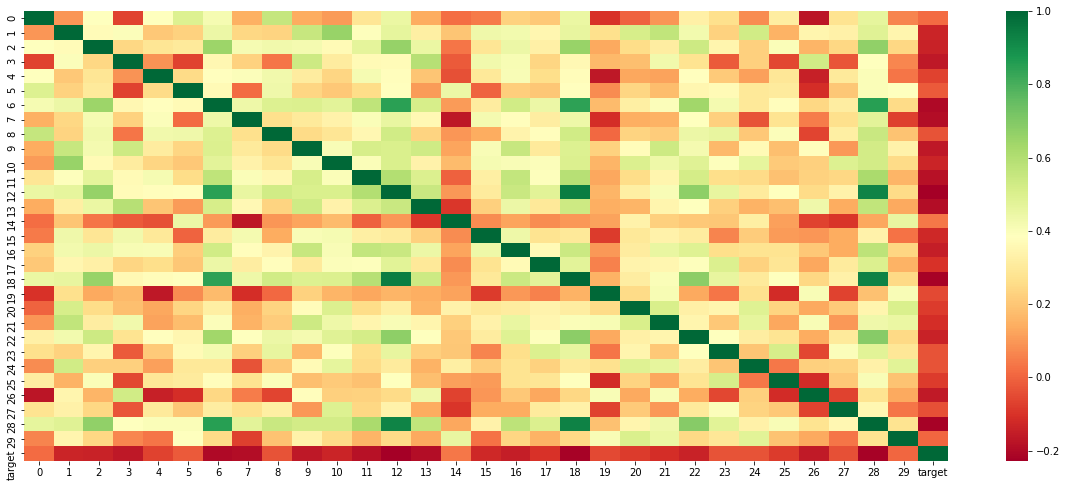

In [23]:
# –í—ã–¥–µ–ª—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏ –º–µ—Ç–∫–∏ –∏–∑ —Å–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ 
print(y_train.shape[0])
data_pd_lda_features_train = data_pd_lda_features.iloc[:y_train.shape[0]]
data_pd_lda_features_train['target'] = y_train
data_pd_lda_features_test = data_pd_lda_features.iloc[y_train.shape[0]:]

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20.7, 8.27)
sns.heatmap(data_pd_lda_features_train.corr(method = 'spearman'), cmap="RdYlGn", ax = ax)

#### –†–∞–∑–±–∏–≤–∞–µ–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é –≤—ã–±–æ—Ä–∫—É –Ω–∞ train –∏ test –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –º–æ–¥–µ–ª–∏

In [24]:
# –î–æ–±–∞–≤–ª—è–µ–º –≤ –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ–ª—É—á–∏–≤—à–∏–π—Å—è –¥–∞—Ç–∞—Å–µ—Ç –∏–∑ –º–æ–¥–µ–ª–∏ lda
X_tr = sparse.hstack([sparse_train, data_pd_lda_features_train.drop('target', axis = 1)]).tocsr()
print(X_tr[:5])

  (0, 5)	4.0
  (0, 6)	1.0
  (0, 25)	5.0
  (0, 27)	5.0
  (0, 37)	3.0
  (0, 42)	5.0
  (0, 49)	2.0
  (0, 58)	1.0
  (0, 60)	22.0
  (0, 62)	1.0
  (0, 66)	1.0
  (0, 79)	2.0
  (0, 94)	2.0
  (0, 105)	2.0
  (0, 124)	2.0
  (0, 142)	3.0
  (0, 144)	1.0
  (0, 148)	1.0
  (0, 157)	2.0
  (0, 158)	1.0
  (0, 159)	1.0
  (0, 163)	1.0
  (0, 169)	1.0
  (0, 173)	18.0
  (0, 186)	3.0
  :	:
  (4, 918)	0.023682566359639168
  (4, 919)	7.491353608202189e-05
  (4, 920)	7.491353608202189e-05
  (4, 921)	0.004885476548224688
  (4, 922)	7.491353608202189e-05
  (4, 923)	7.491353608202189e-05
  (4, 924)	7.491353608202189e-05
  (4, 925)	7.491353608202189e-05
  (4, 926)	7.491353608202189e-05
  (4, 927)	0.06155296787619591
  (4, 928)	7.491353608202189e-05
  (4, 929)	7.491353608202189e-05
  (4, 930)	0.22788651287555695
  (4, 931)	7.491353608202189e-05
  (4, 932)	7.491353608202189e-05
  (4, 933)	7.491353608202189e-05
  (4, 934)	7.491353608202189e-05
  (4, 935)	7.491353608202189e-05
  (4, 936)	7.491353608202189e-05
  (4, 937)	

In [25]:
X_test = sparse.hstack([sparse_test, data_pd_lda_features.iloc[y_train.shape[0]:]]).tocsr()

In [26]:
ridge = Ridge(random_state=17)
ridge.fit(X_tr,y_train)

Ridge(random_state=17)

In [27]:
# –†–µ–∑—É–ª—å—Ç–∞—Ç –∑–∞–≥—Ä—É–∂–∞–µ–º –Ω–∞ Kaggle
subm = ridge.predict(X_test)

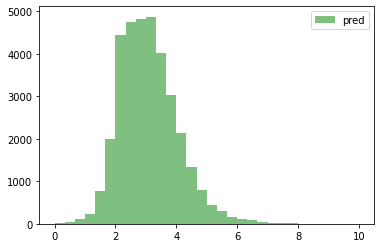

In [28]:
plt.hist(subm, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [29]:
def write_submission(pred, filename, path_to_sample=os.path.join(path_to_data, 'sample_submission.csv')):
    sub = pd.read_csv(path_to_sample, index_col='id')
    sub['log_recommends'] = pred
    sub.to_csv(filename)

In [30]:
write_submission(subm, os.path.join(path_to_data, 'lda_ridge_result.csv'))

### write_submission(ridge_test_pred, os.path.join(path_to_data, 'first_ridge4.csv'))

#### –ü—Ä–µ–¥—ã–¥—É—â–∏–π –∏—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç Kaggle (—Å CountVectorizer) :

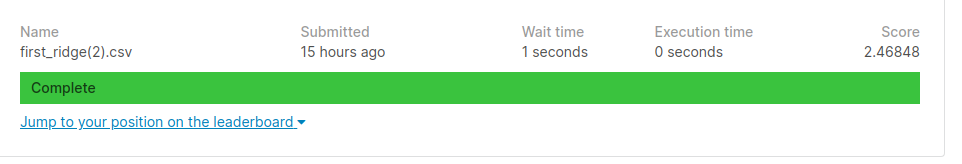

#### –ü—Ä–µ–¥—ã–¥—É—â–∏–π –∏—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç Kaggle (—Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º TF-IDF –º–µ—Ä—ã) :

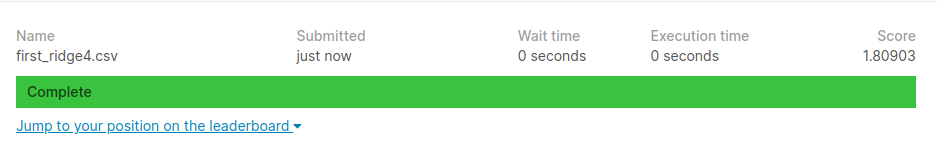


#### –¢–µ–∫—É—â–∏–π –∏—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç Kaggle (—Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ –º–æ–¥–µ–ª–∏ LDA) :

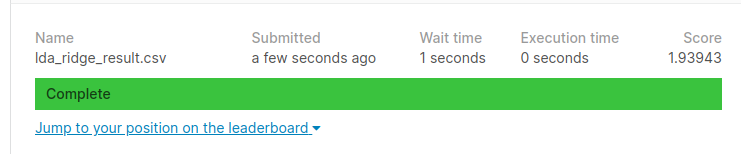

#### –°–¥–µ–ª–∞—Ç—å –≤—ã–±–æ—Ä–∫—É —Ç–æ–ª—å–∫–æ —Å –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ LDA